## Introduction

This Juypter notebook should contain all of the calculations necessary to reproduce the results discussed in the paper.

To begin with, here are the libraries used and version numbers for some of them:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import patches
import astropy.cosmology as apcosmo
import astropy.units as au
import astropy.constants as apconst
import unimachsfr
import scipy.interpolate as spint
import hmf

In [3]:
np.__version__

'1.21.3'

In [4]:
hmf.__version__

'3.4.2'

Just a few lines to set up plotting:

In [5]:
pl.rcParams['text.usetex'] = True
pl.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{tgheros}\usepackage{sansmath}\sansmath'

In [6]:
import seaborn as sns
sns.set_context('talk')

Together, astropy and hmf cover the vast majority of cosmological calculations. The exception is the halo bias mode, which we will define by hand:

In [7]:
def bofM(h):
    '''
    from pcbreysse/lim:
    Halo bias as a function of mass, from Tinker+10 (1001.3162)
    '''

    # nonlinear overdensity
    dc = h.delta_c
    nu = dc/h.sigma

    # Parameters of bias fit
    y = np.log10(200.)
    A = 1. + 0.24*y*np.exp(-(4./y)**4.)
    a = 0.44*y - 0.88
    B = 0.183
    b = 1.5
    C = 0.019 + 0.107*y + 0.19*np.exp(-(4./y)**4.)
    c = 2.4

    return 1.- A*nu**a/(nu**a+dc**a) + B*nu**b + C*nu**c

We define a hmf MassFunction object here. This is more of a dummy instance that we will use to get masses, cosmology, and other quantities that don't really change with redshift.

In [8]:
h = hmf.MassFunction()

In [9]:
cosmo = h.cosmo

And just to show the cosmological parameters used for this work:

In [10]:
cosmo

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [11]:
h.n

0.9667

In [12]:
h.sigma_8

0.8159

In [17]:
littleh = h.cosmo.H0.value/100

We now define a few recurring quantities. First, we define a reference redshift range for integration:

In [18]:
zbins = np.linspace(0,10,1001)

Next, the central $\ell$ values for our angular multipole bins:

In [19]:
ellbins = np.exp(np.linspace(np.log(200),np.log(2000),24))

Then, the frequency channel definitions, with nus being the central frequencies, nu_edges the limits of the frequency band of each channel, and resolving power being nu/channel bandwidth (constant in reality):

In [20]:
nus = np.logspace(np.log10(200),np.log10(300),42)*au.GHz
nu_edges = 10**spint.interp1d(np.arange(42),np.log10(nus.value),fill_value='extrapolate')(np.arange(43)-0.5)
resolving_power = np.mean(nus.value/np.diff(nu_edges))

The last bit of groundwork here is the emissivity, which we approximate as one minus transmission from the APEX ATM calculator:

In [21]:
atm_nu = np.loadtxt('transmission.dat',delimiter=',')[:,0]
atm_t = np.loadtxt('transmission.dat',delimiter=',')[:,1]
emissivity = 1-np.histogram(atm_nu,bins=nu_edges,weights=atm_t)[0]/np.histogram(atm_nu,bins=nu_edges)[0]

## Lensing source galaxies: shear and intrinsic alignment kernels

First, we define a LSST Y1-type distribution:

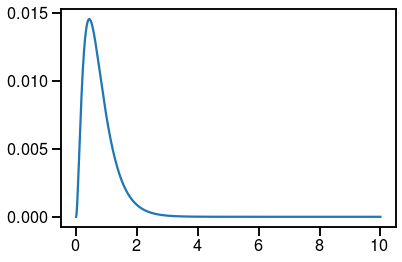

In [22]:
alpha_Y1 = 0.78
z0_Y1 = 0.13
pl.plot(zbins,zbins**2*np.exp(-(zbins/z0_Y1)**alpha_Y1))

In [23]:
nznorm_Y1 = np.trapz(zbins**2*np.exp(-(zbins/z0_Y1)**alpha_Y1),zbins)

In [24]:
nz_Y1 = lambda z:z**2*np.exp(-(z/z0_Y1)**alpha_Y1)/nznorm_Y1

The shear kernel is calculated as follows:

$W_\kappa(\chi)=\frac{3H_0^2\Omega_{m0}}{2c^2}(1+z(\chi))\int d\chi'\,\frac{dz'}{d\chi'}n(z')\frac{\chi(\chi'-\chi)}{\chi'}$

Since we need to work in the basis of comoving distance instead of redshift, we obtain a few interpolation functions and derivatives to calculate this kernel.

In [34]:
chi_to_z = spint.interp1d(cosmo.comoving_distance(zbins).value,zbins,fill_value='extrapolate')
dzdchi = spint.interp1d((zbins[1:]+zbins[:-1])/2,np.diff(zbins)/np.diff(cosmo.comoving_distance(zbins).value),fill_value='extrapolate')(zbins)
chi_to_dzdchi = spint.interp1d(cosmo.comoving_distance(zbins).value,dzdchi,fill_value='extrapolate')
chilim = cosmo.comoving_distance(20).value

In [35]:
Wkappa_chi_Y1 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y1(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)
# units of 1/Mpc in reality

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/4252873278.py:1: RuntimeWarning: invalid value encountered in true_divide
  Wkappa_chi_Y1 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y1(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)


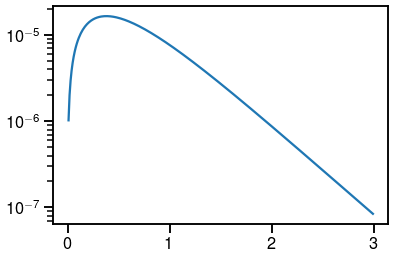

In [36]:
pl.semilogy(zbins[:300],[Wkappa_chi_Y1(chi) for chi in cosmo.comoving_distance(zbins[:300]).value])

What about the intrinsic alignment function?

$W_\text{IA} = -A_\text{IA}C_1\frac{\Omega_{m0}\rho_{c0}}{D(z)}\left(\frac{1+z}{1+z_0}\right)^{\eta_\text{IA}}\frac{dz}{d\chi}n(z)$

So this requires calculation or at least interpolation of the growth factor $D(z)$, which hmf can get for us.

In [37]:
h_for_Dz = hmf.MassFunction()
Dz = []
for z in zbins:
    h_for_Dz.update(z=z)
    Dz.append(h_for_Dz.growth_factor)

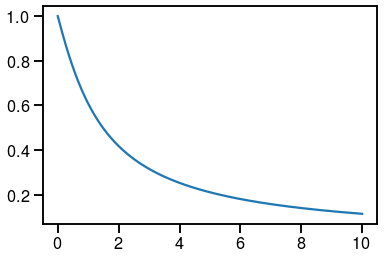

In [38]:
pl.plot(zbins,Dz)

There should be no issue with interpolating this instead of repeatedly calling hmf functions.

In [39]:
Dzinterp = spint.interp1d(zbins,Dz,fill_value='extrapolate')

In [40]:
AIA = 1.
C1 = 5e-14/littleh**2*au.Mpc**3/au.Msun
z0IA = 0.62
etaIA = 3.0

The IA parameters have no dependence on the source density distribution, but the kernel does, so we should distinguish between the IA kernel for LSST Y1 and that for Y10 given the above model:

In [41]:
WIA_chi_Y1 = lambda chi:-AIA*(C1*cosmo.Om0*cosmo.critical_density0/Dzinterp(chi_to_z(chi))*((1+chi_to_z(chi))/(1+z0IA))**etaIA*chi_to_dzdchi(chi)*nz_Y1(chi_to_z(chi))).to(1)
# again actually in units of 1/Mpc

We now repeat the above calculations for a LSST Y10-type source distribution.

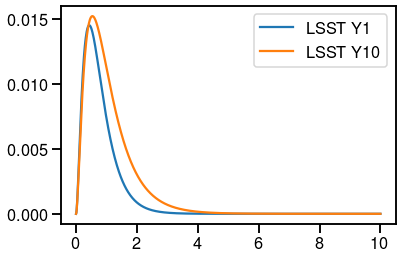

In [42]:
alpha_Y10 = 0.68
z0_Y10 = 0.11
pl.plot(zbins,zbins**2*np.exp(-(zbins/z0_Y1)**alpha_Y1),label='LSST Y1')
pl.plot(zbins,zbins**2*np.exp(-(zbins/z0_Y10)**alpha_Y10),label='LSST Y10')
pl.legend()

In [43]:
nznorm_Y10 = np.trapz(zbins**2*np.exp(-(zbins/z0_Y10)**alpha_Y10),zbins)

In [44]:
nz_Y10 = lambda z:z**2*np.exp(-(z/z0_Y10)**alpha_Y10)/nznorm_Y10

In [45]:
Wkappa_chi_Y10 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y10(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)
WIA_chi_Y10 = lambda chi:-AIA*(C1*cosmo.Om0*cosmo.critical_density0/Dzinterp(chi_to_z(chi))*((1+chi_to_z(chi))/(1+z0IA))**etaIA*chi_to_dzdchi(chi)*nz_Y10(chi_to_z(chi))).to(1)
# again both are supposed to be in units of 1/Mpc

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/4252873278.py:1: RuntimeWarning: invalid value encountered in true_divide
  Wkappa_chi_Y1 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y1(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/2826237776.py:1: RuntimeWarning: invalid value encountered in true_divide
  Wkappa_chi_Y10 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y10(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)


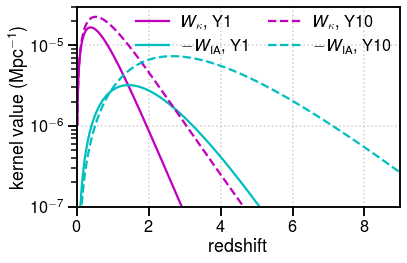

In [47]:
pl.figure().set_tight_layout(True)
pl.semilogy(zbins,[Wkappa_chi_Y1(chi) for chi in cosmo.comoving_distance(zbins).value],'m',label='$W_\\kappa$, Y1')
pl.semilogy(zbins,[-WIA_chi_Y1(chi) for chi in cosmo.comoving_distance(zbins).value],'c',label='$-W_{\\rm IA}$, Y1')
pl.semilogy(zbins,[Wkappa_chi_Y10(chi) for chi in cosmo.comoving_distance(zbins).value],'m--',label='$W_\\kappa$, Y10')
pl.semilogy(zbins,[-WIA_chi_Y10(chi) for chi in cosmo.comoving_distance(zbins).value],'c--',label='$-W_{\\rm IA}$, Y10')
pl.legend(frameon=False,ncol=2,columnspacing=1,borderpad=0)
pl.ylim(1e-7,3e-5)
pl.xlim(0,9)
pl.xlabel('redshift')
pl.ylabel('kernel value (Mpc$^{-1}$)')
pl.grid(True,ls=':',alpha=0.63)
pl.savefig('wl_kernels.png',dpi=288)
pl.savefig('wl_kernels.pdf')

We have now done enough work go ahead and calculate the observed cosmic shear $C_\ell$, including the contribution from IA and shot noise tied to source ellipticities:

In [48]:
sigma_e = 0.26
ng_lens_Y1 = 1.2e8 # sr^{-1}, 10/arcmin^2
ng_lens_Y10 = 3.2e8 # sr^{-1}, 27/arcmin^2

In [49]:
chi_lensint = np.linspace(1,chilim,1001)

This calculation requires us to know the matter power spectrum at each value of $\chi$ being integrated across, and we can interpolate this like we did for $D(z)$:

In [50]:
Pm = []
Plin = []
for z in zbins:
    h_for_Dz.update(z=z)
    Pm.append(spint.interp1d(h_for_Dz.k*littleh,h_for_Dz.nonlinear_power/littleh**3))
    Plin.append(spint.interp1d(h_for_Dz.k*littleh,h_for_Dz.power/littleh**3))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmf/density_field/halofit.py:107: UserWarning: sigma_8 is not used any more, and will be removed in v4
  warnings.warn("sigma_8 is not used any more, and will be removed in v4")


In [51]:
logPm_grid = [np.log10(p(np.logspace(-3,3,6001))) for p in Pm]
logPlin_grid = [np.log10(p(np.logspace(-3,3,6001))) for p in Plin]

In [52]:
Pminterp = spint.RectBivariateSpline(cosmo.comoving_distance(zbins).value,np.linspace(-3,3,6001),logPm_grid)
Plininterp = spint.RectBivariateSpline(cosmo.comoving_distance(zbins).value,np.linspace(-3,3,6001),logPlin_grid)

In [53]:
Cell_lens_tot_Y1 = np.array([np.trapz((Wkappa_chi_Y1(chi_lensint)+WIA_chi_Y1(chi_lensint))**2/\
                                      chi_lensint**2*10**Pminterp(chi_lensint,np.log10(ell/chi_lensint),grid=False),\
                                      chi_lensint) for ell in ellbins]) + sigma_e**2/ng_lens_Y1

In [54]:
Cell_lens_tot_Y10 = np.array([np.trapz((Wkappa_chi_Y10(chi_lensint)+WIA_chi_Y10(chi_lensint))**2/\
                                       chi_lensint**2*10**Pminterp(chi_lensint,np.log10(ell/chi_lensint),grid=False),\
                                       chi_lensint) for ell in ellbins]) + sigma_e**2/ng_lens_Y10

This isn't in the paper, but if you're curious what these shear power spectra look like (with the shape noise subtracted, of course):

(-5e-08, 3.5e-07)

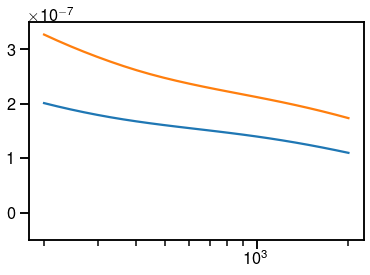

In [55]:
pl.semilogx(ellbins,ellbins*(Cell_lens_tot_Y1-sigma_e**2/ng_lens_Y1))
pl.semilogx(ellbins,ellbins*(Cell_lens_tot_Y10-sigma_e**2/ng_lens_Y10))
pl.ylim(-0.5e-7,3.5e-7)

Finally, while this does not depend on our shear model, we calculate the matter bias that scales the cross spectrum:

In [410]:
h_for_bm = hmf.MassFunction(Mmin=0,dlog10m=0.01)
bm_for_2h = []
bm_for_2h_norm = []
for z in zbins:
    h_for_bm.update(z=z)
    bm_for_2h.append(np.trapz(h_for_bm.dndlog10m*h_for_bm.m/h_for_bm.mean_density0*bofM(h_for_bm),np.log10(h_for_bm.m)))
    bm_for_2h_norm.append(np.trapz(h_for_bm.dndlog10m*h_for_bm.m/h_for_bm.mean_density0,np.log10(h_for_bm.m)))

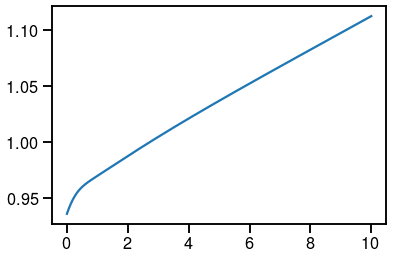

In [411]:
pl.plot(zbins,np.array(bm_for_2h)/np.array(bm_for_2h_norm))

In [117]:
np.max(np.array(bm_for_2h)/np.array(bm_for_2h_norm))

1.1126723029447771

In [118]:
np.min(np.array(bm_for_2h)/np.array(bm_for_2h_norm))

0.9354233444478038

We can also check that the density consistency relation (the integral of the hmf times the halo mass really should equal the mean matter density) fails to even approximately hold at high redshift due to the limitations of our hmf model:

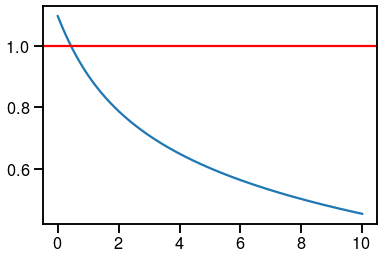

In [120]:
pl.plot(zbins,bm_for_2h_norm)
pl.axhline(1,color='red')

In [121]:
bm_normed_interp = spint.interp1d(zbins,np.array(bm_for_2h)/np.array(bm_for_2h_norm))

## Line-intensity models

In [122]:
CLI = lambda z,nu0:299792458*au.m/au.s/(4.*np.pi*au.sr*nu0*cosmo.H(z))

In [123]:
Js = (3,4,4.27,5,6,7)

Note that $J=4.27$ actually corresponds to CI(1-0) rather than a CO line. We treat the CI line in this way because the Sun+ model scales both the CO lines and the CI line from a model for CO(1-0) luminosity.

In [124]:
rJs = (0.73,0.57,0.18,0.32,0.19,0.1)

In [125]:
CO_CI_label = {J:'CI' if J%1 else J for J in Js}

In [126]:
hmfs_for_CO_CI = {J:{nuobs:hmf.MassFunction(z=115.27*J/nuobs-1) if nuobs < 115.27*J else None for nuobs in nus.value} for J in Js}

In [127]:
hmfs_for_CII = {nuobs:hmf.MassFunction(z=1901.0302/nuobs-1) if nuobs < 1901.0302 else None for nuobs in nus.value}

Pre-defining the hmf objects takes a while, but after this calculating integrated quantities is fairly quick.

In [128]:
I_CII = [(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)*np.trapz(hmfs_for_CII[nuobs].dndlog10m*10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value for nuobs in nus.value]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/1616487378.py:1: RuntimeWarning: divide by zero encountered in log10
  I_CII = [(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)*np.trapz(hmfs_for_CII[nuobs].dndlog10m*10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value for nuobs in nus.value]


In [129]:
I_CO_CI = {J:[(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
               np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*\
                        10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*\
                        rJ*J**3,np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value\
              if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

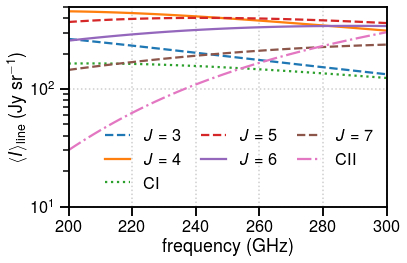

In [290]:
pl.figure().set_tight_layout(True)
for J in Js:
    pl.semilogy(nus.value,I_CO_CI[J],label='{}{}{}'.format((J%1==0)*'$J=',CO_CI_label[J],(J%1==0)*'$'),ls=(':' if J%1 else '-'*(J%2+1)))
pl.semilogy(nus.value,I_CII,label='CII',ls='-.')
pl.grid(True,ls=':',alpha=0.63)
pl.ylim(1e1,5e2)
pl.xlim(200,300)
pl.legend(ncol=3,frameon=False,columnspacing=1.25,handlelength=1.5)
pl.xlabel('frequency (GHz)')
pl.ylabel(r'$\langle I\rangle_\text{line}$ (Jy sr$^{-1}$)')
pl.savefig('Iline.png',dpi=288)
pl.savefig('Iline.pdf')

In [131]:
nus.value[23]

251.08044927153108

In [132]:
[print(CO_CI_label[J],I_CO_CI[J][23]) for J in Js]
print('CII',I_CII[23])

3 187.6817585631142
4 395.83059448768387
CI 151.49920505915767
5 400.26442054255625
6 327.65586232405167
7 202.89384869414351
CII 139.9206177656161


For $C_\ell$, however, the relevant quantity will be the mean intensity-bias product rather than the mean intensity on its own. (There is also the shot noise to consider, although our imposed $\ell_\text{max}$ keeps that minimally relevant.)

In [133]:
Ib_CII = [(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)*np.trapz(hmfs_for_CII[nuobs].dndlog10m*bofM(hmfs_for_CII[nuobs])*10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value for nuobs in nus.value]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/525104734.py:1: RuntimeWarning: divide by zero encountered in log10
  Ib_CII = [(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)*np.trapz(hmfs_for_CII[nuobs].dndlog10m*bofM(hmfs_for_CII[nuobs])*10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value for nuobs in nus.value]


In [134]:
Ib_CO_CI = {J:[(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3,np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

In [135]:
Pshot_scatter_factor = np.exp((0.4*np.log(10))**2)

In [136]:
Pshot_CII = [Pshot_scatter_factor*(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)**2*np.trapz(hmfs_for_CII[nuobs].dndlog10m*10**(2*(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34)),np.log10(h.m))*au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value for nuobs in nus.value]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/2516000097.py:1: RuntimeWarning: divide by zero encountered in log10
  Pshot_CII = [Pshot_scatter_factor*(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)**2*np.trapz(hmfs_for_CII[nuobs].dndlog10m*10**(2*(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34)),np.log10(h.m))*au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value for nuobs in nus.value]


In [137]:
Pshot_CO_CI = {J:[Pshot_scatter_factor*(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)**2*np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*(10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3)**2,np.log10(h.m))*au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

Converting 3D power spectra to angular power spectra requires us to know the comoving shell width corresponding to each channel.

In [138]:
deltachi_CO_CI = {J:np.abs(np.diff(cosmo.comoving_distance(115.27*J/nu_edges-1))) for J in Js}

In [139]:
deltachi_CII = np.abs(np.diff(cosmo.comoving_distance(1901.0302/nu_edges-1)))

In [140]:
EXAMPLE_CHANNEL = 21

In [141]:
Pm_for_CII = [spint.interp1d(hmfs_for_CII[nuobs].k*littleh,hmfs_for_CII[nuobs].power/littleh**3) for nuobs in nus.value]

In [142]:
Pm_for_CO_CI = {J:[spint.interp1d(hmfs_for_CO_CI[J][nuobs].k*littleh,hmfs_for_CO_CI[J][nuobs].power/littleh**3) for nuobs in nus.value] for J in Js}

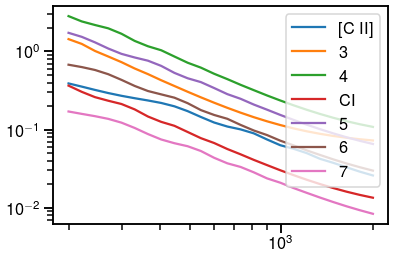

In [143]:
pl.loglog(ellbins,1/deltachi_CII[EXAMPLE_CHANNEL]*(Pshot_CII[EXAMPLE_CHANNEL]+Ib_CII[EXAMPLE_CHANNEL]**2*Pm_for_CII[EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((1901.0302*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))*au.Mpc**3/cosmo.comoving_distance((1901.0302*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2,label='[C II]')
for J in Js:
    pl.loglog(ellbins,1/deltachi_CO_CI[J][EXAMPLE_CHANNEL]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2*(Pshot_CO_CI[J][EXAMPLE_CHANNEL]+Ib_CO_CI[J][EXAMPLE_CHANNEL]**2*Pm_for_CO_CI[J][EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))*au.Mpc**3,label=CO_CI_label[J])
pl.legend()

We also need LIM x LIM cross spectra for covariance purposes. This is a slightly complex thing, but is tractable. First, we need to establish which channels in which lines overlap with which other channels in which other lines. We may safely exclude CII in this particular context.

In [144]:
Theta_switchertable = {(nu,nu2,J,J2):np.abs(115.27*J/nu-115.27*J2/nu2)<0.5/resolving_power*115.27*(J*J2/(nu*nu2))**0.5 for J in Js for J2 in Js for nu in nus.value for nu2 in nus.value}

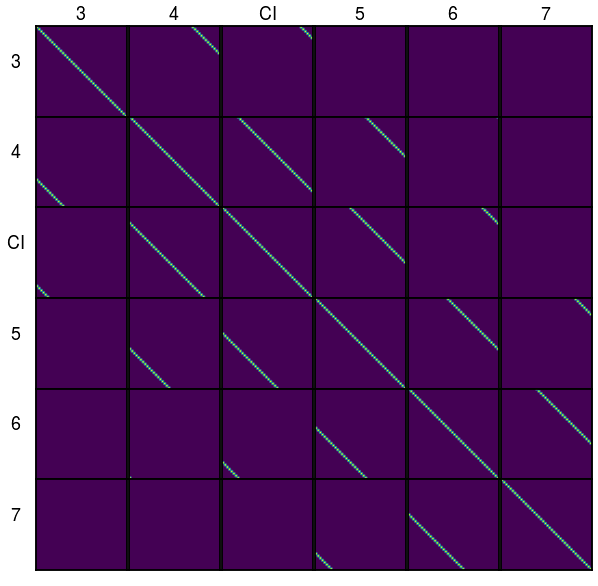

In [145]:
pl.figure(figsize=(10,10))
pl.subplots_adjust(hspace=0.0,wspace=0.0)
for i,J in enumerate(Js):
    for ii,J2 in enumerate(Js):
        pl.subplot(len(Js),len(Js),1+i+ii*len(Js))
        pl.imshow([[Theta_switchertable[(nu1,nu2,J,J2)] for nu1 in nus.value] for nu2 in nus.value])
        if ii==0: pl.title(CO_CI_label[J])
        pl.gca().set_xticks(())
        pl.gca().set_yticks(())
        if i==0: pl.ylabel(CO_CI_label[J2],rotation=0,labelpad=20)

Again, for this purpose we are supposed to calculate total observed $C_\ell$, including noise, but unlike with the lensing $C_\ell$ the signal is insensitive to parameters relevant to noise. So we can calculate the noiseless spectra first and then add noise down the line.

In [146]:
Cell_LIMLIM_noiseless = np.zeros((len(nus.value),len(nus.value),len(ellbins)))
for i,nu in enumerate(nus.value):
    for ii,nu2 in enumerate(nus.value):
        # treating CII as its own special case
        if i==ii:
            Cell_LIMLIM_noiseless[i,ii] += (1/deltachi_CII[i]*(Pshot_CII[i]+Ib_CII[i]**2*\
                        Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nu-1).value))*au.Mpc**3/\
                                    cosmo.comoving_distance(1901.0302/nu-1)**2).to(1).value
        # now iterate through CO and CI using our table for Theta
        for J,rJ in zip(Js,rJs):
            for J2,rJ2 in zip(Js,rJs):
                if Theta_switchertable[(nu,nu2,J,J2)]:
                    deltachi_avg = np.sqrt(deltachi_CO_CI[J][i]*deltachi_CO_CI[J2][ii])
                    chi_avg = np.sqrt(cosmo.comoving_distance(115.27*J/nu-1)*\
                                       cosmo.comoving_distance(115.27*J2/nu2-1))
                    dndlog10m_avg = (hmfs_for_CO_CI[J][nu].dndlog10m+hmfs_for_CO_CI[J2][nu2].dndlog10m)/2
                    LofM_J = (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nu-1)*1.5)+\
                                                10.76)/1.27-4.31)*rJ*J**3)
                    LofM_J2 = (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J2/nu2-1)*1.5)+\
                                                10.76)/1.27-4.31)*rJ2*J2**3)
                    Pshot_cross = Pshot_scatter_factor*(CLI(115.27*J/nu-1,115.27*J*au.GHz)*\
                                                        CLI(115.27*J2/nu2-1,115.27*J2*au.GHz)*\
                                        np.trapz(dndlog10m_avg*LofM_J*LofM_J2,np.log10(h.m))*au.Lsun**2/au.Mpc**3*\
                                                        littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value
                    Cell_LIMLIM_noiseless[i,ii] += (1/deltachi_avg/chi_avg**2*\
                        (Pshot_cross+Ib_CO_CI[J][i]*Ib_CO_CI[J2][ii]*\
                         10**Plininterp(np.ones_like(ellbins)*chi_avg.value,np.log10(ellbins/chi_avg.value),\
                                  grid=False))*au.Mpc**3).to(1).value

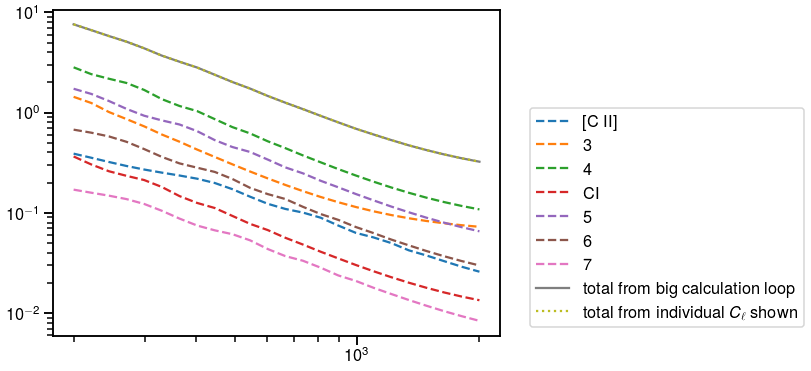

In [147]:
pl.figure(figsize=(8,6))
Cell_CII_for_example_channel = 1/deltachi_CII[EXAMPLE_CHANNEL]*(Pshot_CII[EXAMPLE_CHANNEL]+Ib_CII[EXAMPLE_CHANNEL]**2*Pm_for_CII[EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((1901.0302*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))*au.Mpc**3/cosmo.comoving_distance((1901.0302*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2
Cell_total_example = 1.*Cell_CII_for_example_channel
pl.loglog(ellbins,Cell_CII_for_example_channel,'--',label='[C II]')
for J in Js:
    Cell_CO_for_example_channel = 1/deltachi_CO_CI[J][EXAMPLE_CHANNEL]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2*(Pshot_CO_CI[J][EXAMPLE_CHANNEL]+Ib_CO_CI[J][EXAMPLE_CHANNEL]**2*Pm_for_CO_CI[J][EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))*au.Mpc**3
    pl.loglog(ellbins,Cell_CO_for_example_channel,'--',label=CO_CI_label[J])
    Cell_total_example+= Cell_CO_for_example_channel
pl.loglog(ellbins,Cell_LIMLIM_noiseless[EXAMPLE_CHANNEL,EXAMPLE_CHANNEL],label='total from big calculation loop')
pl.loglog(ellbins,Cell_total_example,':',label='total from individual $C_\ell$ shown')
pl.legend(loc='lower right',bbox_to_anchor=(1.7,0))

Perfect! What do the cross spectra look like?

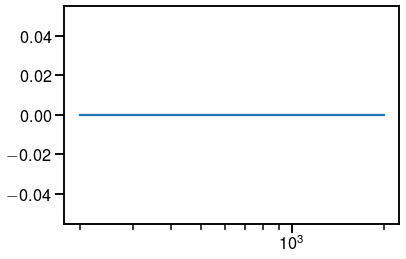

In [148]:
pl.semilogx(ellbins,Cell_LIMLIM_noiseless[21,23])

OK, bad example. There's nothing to cross-correlate positively here. But:

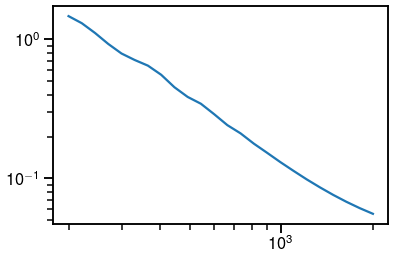

In [149]:
pl.loglog(ellbins,Cell_LIMLIM_noiseless[21,39])

Aha! This pair of channels does have a correlation between $J=5$ and $J=6$.

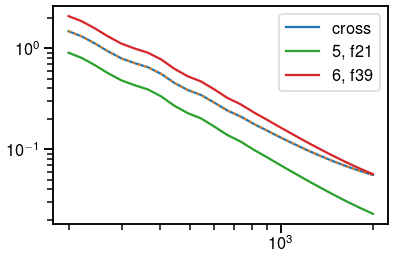

In [150]:
pl.loglog(ellbins,Cell_LIMLIM_noiseless[21,39],label='cross')
pl.loglog(ellbins,Cell_LIMLIM_noiseless[39,21],':')
pl.loglog(ellbins,1/deltachi_CO_CI[3][21]/cosmo.comoving_distance((115.27*Js[3]*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[3][21]+Ib_CO_CI[3][21]**2*Pm_for_CO_CI[3][21](ellbins/cosmo.comoving_distance((115.27*Js[3]*au.GHz/nus-1)[21]).value))*au.Mpc**3,label='{}, f21'.format(Js[3]))
pl.loglog(ellbins,1/deltachi_CO_CI[4][39]/cosmo.comoving_distance((115.27*Js[4]*au.GHz/nus-1)[39])**2*(Pshot_CO_CI[4][39]+Ib_CO_CI[4][39]**2*Pm_for_CO_CI[4][39](ellbins/cosmo.comoving_distance((115.27*Js[4]*au.GHz/nus-1)[39]).value))*au.Mpc**3,label='{}, f39'.format(Js[4]))
pl.legend()

So the sanity check works in that the cross is roughly in the middle of the two autos (although with enhanced cross shot noise compared to the auto shot noise in either line), and our $C_\ell$ matrix is symmetric between the two frequency dimensions.

## Detectability

In [151]:
fsky_8sqdeg = 8/41253
fsky_1000sqdeg = 1000/41253

In [152]:
Cell_noise_FYSTlike = 4*np.pi*fsky_8sqdeg*1e6**2/120/4000/3600

In [153]:
Cell_LIMLIM_FYSTlike = np.diag(emissivity/0.05/(nus.value/resolving_power/2.5)*Cell_noise_FYSTlike)[...,None] + Cell_LIMLIM_noiseless

In [154]:
Cell_cross_Y1 = [sum([np.array(Ib_CO_CI[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*(Wkappa_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+WIA_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js])+np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*(Wkappa_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+WIA_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2) for i in range(len(nus.value))]

In [155]:
covar_perchannel_FYSTlike_Y1 = [(Cell_LIMLIM_FYSTlike[i,i]*Cell_lens_tot_Y1+Cell_cross_Y1[i]**2)/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))\
                                /fsky_8sqdeg for i in range(len(nus.value))]

In [156]:
print(np.sum(Cell_cross_Y1[EXAMPLE_CHANNEL]**2/covar_perchannel_FYSTlike_Y1[EXAMPLE_CHANNEL])**0.5)

0.3630797646379693


In [157]:
np.array(covar_perchannel_FYSTlike_Y1).shape

(42, 24)

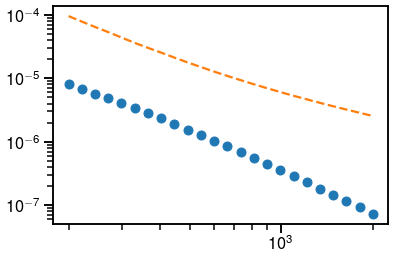

In [158]:
pl.loglog(ellbins,Cell_cross_Y1[EXAMPLE_CHANNEL],'o')
pl.loglog(ellbins,covar_perchannel_FYSTlike_Y1[EXAMPLE_CHANNEL]**0.5,'--')

In [159]:
Cell_noise_CplusS3 = 4*np.pi*fsky_1000sqdeg*1e6**2/15000/12000/3600

In [160]:
Cell_LIMLIM_CplusS3 = np.diag(emissivity/0.05/(nus.value/resolving_power/2.5)*Cell_noise_CplusS3)[...,None] + Cell_LIMLIM_noiseless

In [161]:
Cell_cross_Y10 = [sum([np.array(Ib_CO_CI[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+WIA_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js])+np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+WIA_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2) for i in range(len(nus.value))]

In [162]:
covar_perchannel_CplusS3_Y10 = [(Cell_LIMLIM_CplusS3[i,i]*Cell_lens_tot_Y10+Cell_cross_Y10[i]**2)/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))\
                                /fsky_1000sqdeg for i in range(len(nus.value))]

In [163]:
print(np.sum(Cell_cross_Y10[EXAMPLE_CHANNEL]**2/covar_perchannel_CplusS3_Y10[EXAMPLE_CHANNEL])**0.5)

10.869207375307187


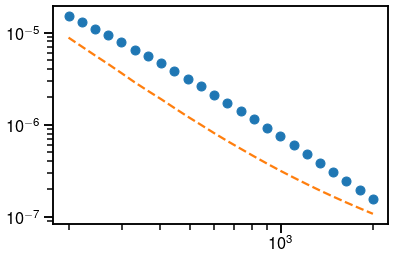

In [164]:
pl.loglog(ellbins,Cell_cross_Y10[EXAMPLE_CHANNEL],'o')
pl.loglog(ellbins,covar_perchannel_CplusS3_Y10[EXAMPLE_CHANNEL]**0.5,'--')

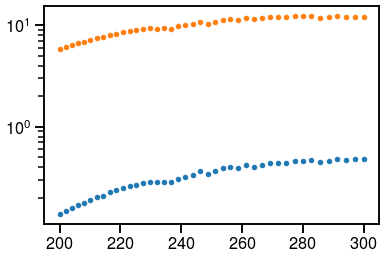

In [165]:
pl.semilogy(nus.value,[(np.sum(Cell_cross_Y1[i]**2/covar_perchannel_FYSTlike_Y1[i])**0.5) for i in range(len(nus.value))],'.')
pl.semilogy(nus.value,[(np.sum(Cell_cross_Y10[i]**2/covar_perchannel_CplusS3_Y10[i])**0.5) for i in range(len(nus.value))],'.')

How does this signal break down by the way? Let's consider $C_{\ell\approx500}$.

In [168]:
Cell_cross_Y10_breakdown = [[np.array(Ib_CO_CI[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+WIA_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js]+[np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+WIA_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2)] for i in range(len(nus.value))]

In [169]:
ellbins[9]

492.4184802989251

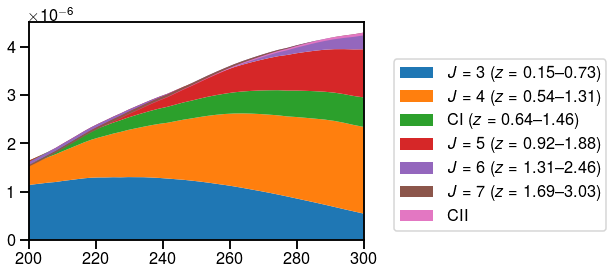

In [170]:
pl.stackplot(nus.value,np.array(Cell_cross_Y10_breakdown)[...,9].T,labels=['{}{}{} ($z={:.2f}$--${:.2f}$)'.format((J%1==0)*'$J=',CO_CI_label[J],(J%1==0)*'$',115.27*J/nus.value[-1]-1,115.27*J/nus.value[0]-1) for J in Js]+['CII'])
pl.xlim(200,300)
pl.legend(loc='lower right',bbox_to_anchor=(1.75,0))

In [171]:
Cell_cross_Y10_breakdown_noIA = [[np.array(Ib_CO_CI[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js]+[np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+WIA_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2)] for i in range(len(nus.value))]

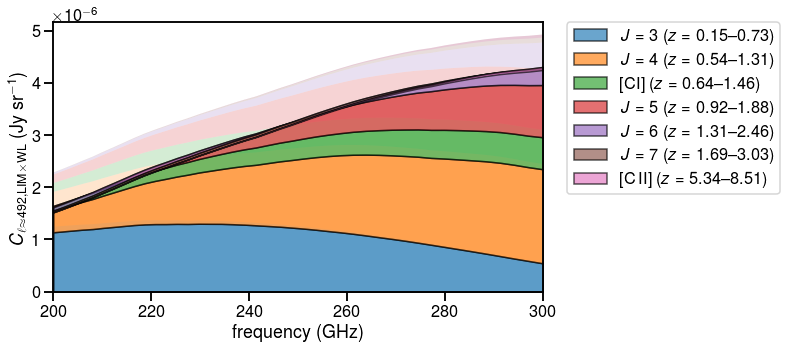

In [364]:
pl.figure(figsize=(17,5))
pl.subplots_adjust(left=0.15,right=0.95,top=0.95,bottom=0.2,hspace=0,wspace=0)
pl.subplot(121)
pl.stackplot(nus.value,np.array(Cell_cross_Y10_breakdown_noIA)[...,9].T,colors=[pl.cm.tab10(iii) for iii in range(7)],alpha=0.2)
pl.stackplot(nus.value,np.array(Cell_cross_Y10_breakdown)[...,9].T,labels=['{}{}{} ($z={:.2f}$--${:.2f}$)'.format(('$J=' if J%1==0 else '['),CO_CI_label[J],('$' if J%1==0 else ']'),115.27*J/nus.value[-1]-1,115.27*J/nus.value[0]-1) for J in Js]+[r'[C\textsc{{\,II}}] ($z={:.2f}$--${:.2f}$)'.format(1901.0302/nus.value[-1]-1,1901.0302/nus.value[0]-1)],colors=[pl.cm.tab10(iii) for iii in range(7)],ec='k',alpha=0.66)
pl.xlim(200,300)
pl.xlabel('frequency (GHz)')
pl.ylabel(r'$C_{\ell\approx492,\text{LIM}\times\text{WL}}$ (Jy sr$^{-1}$)')
pl.legend(loc='lower right',bbox_to_anchor=(1.5,0.33))
pl.savefig('cell_break.png',bbox_inches='tight',dpi=288)
pl.savefig('cell_break.pdf',bbox_inches='tight')

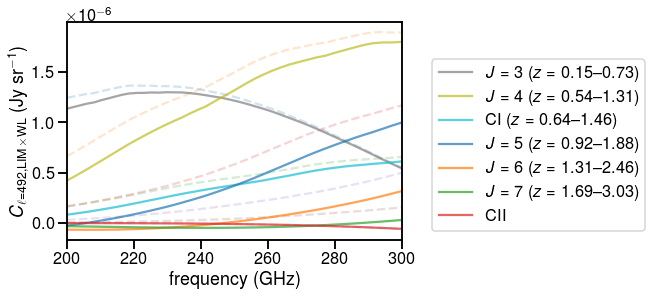

In [206]:
pl.plot(nus.value,np.array(Cell_cross_Y10_breakdown_noIA)[...,9],'--',alpha=0.2)
pl.plot(nus.value,np.array(Cell_cross_Y10_breakdown)[...,9],label=['{}{}{} ($z={:.2f}$--${:.2f}$)'.format((J%1==0)*'$J=',CO_CI_label[J],(J%1==0)*'$',115.27*J/nus.value[-1]-1,115.27*J/nus.value[0]-1) for J in Js]+['CII'],alpha=0.7)
pl.xlim(200,300)
pl.xlabel('frequency (GHz)')
pl.ylabel(r'$C_{\ell=492,\text{LIM}\times\text{WL}}$ (Jy sr$^{-1}$)')
pl.legend(loc='lower right',bbox_to_anchor=(1.75,0))

In [175]:
observable_vector_Y1 = np.hstack(Cell_cross_Y1)

This vector iterates through all $\ell$ before stepping in channel frequency. Like this:

In [173]:
observable_basis = [(nu,ell) for nu in nus.value for ell in ellbins]

In [174]:
observable_basis

[(200.00000000000003, 199.99999999999991),
 (200.00000000000003, 221.05902822520426),
 (200.00000000000003, 244.33546979935838),
 (200.00000000000003, 270.0628075739746),
 (200.00000000000003, 298.49910901036566),
 (200.00000000000003, 329.92961481960384),
 (200.00000000000003, 364.669600173688),
 (200.00000000000003, 403.0675371883465),
 (200.00000000000003, 445.5085903999114),
 (200.00000000000003, 492.4184802989251),
 (200.00000000000003, 544.2677536750615),
 (200.00000000000003, 601.57650360862),
 (200.00000000000003, 664.9195864541883),
 (200.00000000000003, 734.9323881473381),
 (200.00000000000003, 812.3171976753955),
 (200.00000000000003, 897.8502516437208),
 (200.00000000000003, 992.3895206005806),
 (200.00000000000003, 1096.8833152242037),
 (200.00000000000003, 1212.3797986995148),
 (200.00000000000003, 1340.0375007019168),
 (200.00000000000003, 1481.1369384524867),
 (200.00000000000003, 1637.093461413805),
 (200.00000000000003, 1809.4714484698588),
 (200.00000000000003, 1999.

In [176]:
covar_FYSTlike_Y1 = np.array(\
                             [[0 if ell1!=ell2 else \
                      ((Cell_LIMLIM_FYSTlike[np.where(nus.value==nu1)[0][0],np.where(nus.value==nu2)[0][0]]*\
                       Cell_lens_tot_Y1+\
                     Cell_cross_Y1[np.where(nus.value==nu1)[0][0]]*Cell_cross_Y1[np.where(nus.value==nu2)[0][0]]\
                    )/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))/fsky_8sqdeg)[np.where(ellbins==ell1)[0][0]]\
                     for nu1,ell1 in observable_basis]\
                     for nu2,ell2 in observable_basis])

In [178]:
np.matmul(observable_vector_Y1,np.matmul(np.linalg.inv(covar_FYSTlike_Y1),observable_vector_Y1))**0.5

1.8878439630980528

In [210]:
covar_CplusS3_Y10 = np.array(\
                             [[0 if ell1!=ell2 else \
                      ((Cell_LIMLIM_CplusS3[np.where(nus.value==nu1)[0][0],np.where(nus.value==nu2)[0][0]]*\
                       Cell_lens_tot_Y10+\
                     Cell_cross_Y10[np.where(nus.value==nu1)[0][0]]*Cell_cross_Y10[np.where(nus.value==nu2)[0][0]]\
                    )/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))/fsky_1000sqdeg)[np.where(ellbins==ell1)[0][0]]\
                     for nu1,ell1 in observable_basis]\
                     for nu2,ell2 in observable_basis])

In [211]:
observable_vector_Y10 = np.hstack(Cell_cross_Y10)

In [212]:
np.matmul(observable_vector_Y10,np.matmul(np.linalg.inv(covar_CplusS3_Y10),observable_vector_Y10))**0.5

49.97799423128316

All this checks out---roughly on the order of the per-channel S/N scaled by sqrt(Nchan). A re-plot of that just to remind you:

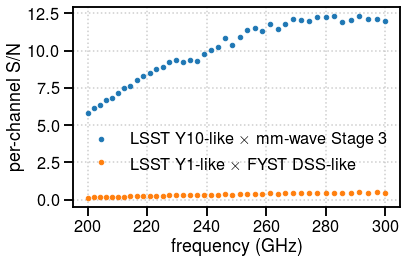

In [307]:
pl.figure().set_tight_layout(True)
pl.plot(nus.value,[(np.sum(Cell_cross_Y10[i]**2/covar_perchannel_CplusS3_Y10[i])**0.5) for i in range(len(nus.value))],'.',label='LSST Y10-like $\\times$ mm-wave Stage 3')
pl.plot(nus.value,[(np.sum(Cell_cross_Y1[i]**2/covar_perchannel_FYSTlike_Y1[i])**0.5) for i in range(len(nus.value))],'.',label='LSST Y1-like $\\times$ FYST DSS-like')
pl.xlabel('frequency (GHz)')
pl.ylabel('per-channel S/N')
pl.legend(loc='lower center',frameon=False,bbox_to_anchor=(0.5,0.1))
pl.grid(ls=':',alpha=0.63)
pl.savefig('sn_perch.pdf')
pl.savefig('sn_perch.png',dpi=288)

Of course, were we not taking off-diagonal covariances into account, we would have ended up with higher S/N:

In [294]:
sum([(np.sum(Cell_cross_Y1[i]**2/covar_perchannel_FYSTlike_Y1[i])) for i in range(len(nus.value))])**0.5

2.2788580401511775

In [295]:
sum([(np.sum(Cell_cross_Y10[i]**2/covar_perchannel_CplusS3_Y10[i])) for i in range(len(nus.value))])**0.5

66.135884076901

## Fisher forecasting

We need to be able to derive the observable vector as a function of model parameters. We'll pick the two parameters controlling the SFR-to-CO(1-0) relation as well as the IA kernel amplitude.

In [214]:
def observable_vector_Y1_recalc(alphaCO,betaCO,AIAnew):
    Ib_CO_CI_recalc = {J:[(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                           np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*\
                                    10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)\
                                          +9.76-betaCO)/alphaCO-4.31)*rJ*J**3,np.log10(h.m))*\
                           au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value \
                          if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}
    '''
    Pshot_CO_CI_recalc = {J:[Pshot_scatter_factor*\
                             (CLI(115.27*J/nuobs-1,115.27*J*au.GHz)**2*\
                              np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*\
                                       (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1))\
                                              +9.76-betaCO)/alphaCO-4.31)*rJ*J**3)**2,np.log10(h.m))*\
                              au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value \
                             if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}
    '''
    return np.hstack([sum([np.array(Ib_CO_CI_recalc[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*\
                                    (Wkappa_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                  WIA_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)/AIA*AIAnew)/\
                  au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*\
                  au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js])\
                      +np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*\
                                (Wkappa_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+\
                                           WIA_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)\
                                          )/au.Mpc*\
                                Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)\
                                *au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2)
                      for i in range(len(nus.value))])

In [215]:
np.allclose(observable_vector_Y1_recalc(1.27,-1.00,AIA),observable_vector_Y1)

True

In [220]:
def observable_vector_Y10_recalc(alphaCO,betaCO,AIAnew):
    Ib_CO_CI_recalc = {J:[(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                           np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*\
                                    10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)\
                                          +9.76-betaCO)/alphaCO-4.31)*rJ*J**3,np.log10(h.m))*\
                           au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value \
                          if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}
    '''
    Pshot_CO_CI_recalc = {J:[Pshot_scatter_factor*\
                             (CLI(115.27*J/nuobs-1,115.27*J*au.GHz)**2*\
                              np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*\
                                       (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1))\
                                              +9.76-betaCO)/alphaCO-4.31)*rJ*J**3)**2,np.log10(h.m))*\
                              au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value \
                             if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}
    '''
    return np.hstack([sum([np.array(Ib_CO_CI_recalc[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*\
                                    (Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                  WIA_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)/AIA*AIAnew)/\
                  au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*\
                  au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js])\
                      +np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*\
                                (Wkappa_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+\
                                           WIA_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)\
                                          )/au.Mpc*\
                                Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)\
                                *au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2)
                      for i in range(len(nus.value))])

In [221]:
np.allclose(observable_vector_Y10_recalc(1.27,-1.00,AIA),observable_vector_Y10)

True

In [222]:
FISHER_DPARAM = 0.1

In [245]:
param_labels = ('$\\alpha_\\text{IR--CO}$','$\\beta_\\text{IR--CO}$','$A_\\text{IA}$')

In [224]:
fiducial = (1.27,-1.00,AIA)

In [225]:
prior_widths = np.array((np.inf,np.inf,0.5))

In [226]:
fisher_priors_only = np.diag(prior_widths**-2)

In [227]:
observable_derivatives_Y1 = [(observable_vector_Y1_recalc(*tuple(np.array(fiducial)+FISHER_DPARAM*(np.arange(len(fiducial))==i)))-observable_vector_Y1_recalc(*tuple(np.array(fiducial)-FISHER_DPARAM*(np.arange(len(fiducial))==i))))/FISHER_DPARAM/2 for i in range(len(fiducial))]

In [228]:
observable_derivatives_Y10 = [(observable_vector_Y10_recalc(*tuple(np.array(fiducial)+FISHER_DPARAM*(np.arange(len(fiducial))==i)))-observable_vector_Y10_recalc(*tuple(np.array(fiducial)-FISHER_DPARAM*(np.arange(len(fiducial))==i))))/FISHER_DPARAM/2 for i in range(len(fiducial))]

In [229]:
[d.shape for d in observable_derivatives_Y1]

[(1008,), (1008,), (1008,)]

In [230]:
fisher_Y1 = [[np.matmul(observable_derivatives_Y1[i],np.matmul(np.linalg.inv(covar_FYSTlike_Y1),observable_derivatives_Y1[ii])) for i in range(len(fiducial))] for ii in range(len(fiducial))]
fisher_Y1+= fisher_priors_only

In [231]:
cov_params_Y1 = np.linalg.inv(fisher_Y1)

In [232]:
np.diagonal(cov_params_Y1)**0.5

array([ 1.67315309, 24.17006169,  0.49932135])

In [233]:
fisher_Y10 = [[np.matmul(observable_derivatives_Y10[i],np.matmul(np.linalg.inv(covar_CplusS3_Y10),observable_derivatives_Y10[ii])) for i in range(len(fiducial))] for ii in range(len(fiducial))]
fisher_Y10+= fisher_priors_only

In [234]:
cov_params_Y10 = np.linalg.inv(fisher_Y10)

In [235]:
np.diagonal(cov_params_Y10)**0.5

array([0.11789822, 1.71018734, 0.3574829 ])

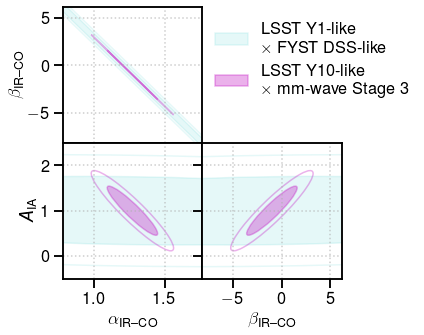

In [374]:
pl.figure(figsize=(5,5))
pl.subplots_adjust(hspace=0,wspace=0)
for i,ilabel in enumerate(param_labels):
    for j,jlabel in enumerate(param_labels):
        if i >= j: continue;
        #pl.subplot(len(fiducial),len(fiducial),j*len(fiducial)+i+1)
        pl.subplot(len(fiducial)-1,len(fiducial)-1,(j-1)*(len(fiducial)-1)+i+1)
        if j < len(fiducial)-1:
            pl.gca().set_xticklabels([])
        else:
            pl.xlabel(ilabel)
        if i > 0:
            pl.gca().set_yticklabels([])
        else:
            if i!=j:
                pl.ylabel(jlabel)
        if i== j:
            '''
            pl.gca().set_yticks([])
            xtmp = np.linspace(fiducial[i]-4.2*cov_params_Y10[i,i]**0.5,fiducial[i]+4.2*cov_params_Y10[i,i]**0.5,101)
            pl.plot(xtmp,np.exp(-(xtmp-fiducial[i])**2/cov_params_Y10[i,i]/2),'m')
            pl.grid(True,axis='x',alpha=0.63,ls=':')
            pl.xlim((fiducial[i]-4.2*cov_params_Y10[i,i]**0.5),fiducial[i]+4.2*cov_params_Y10[i,i]**0.5)
            '''
            continue;
        abp = (cov_params_Y1[i,i]+cov_params_Y1[j,j])/2
        abm = ((cov_params_Y1[i,i]-cov_params_Y1[j,j])**2/4+cov_params_Y1[i,j]*cov_params_Y1[j,i])**0.5
        angle = np.arctan2((cov_params_Y1[i,j]+cov_params_Y1[j,i]),(cov_params_Y1[i,i]-cov_params_Y1[j,j]))/2
        pl.gca().add_patch(patches.Ellipse((fiducial[i],fiducial[j]),1.52*2*(abp+abm)**0.5,1.52*2*(abp-abm)**0.5,angle=angle*180/np.pi,alpha=0.1,color='c',label='LSST Y1-like\n$\\times$ FYST DSS-like'))
        pl.gca().add_patch(patches.Ellipse((fiducial[i],fiducial[j]),2.48*2*(abp+abm)**0.5,2.48*2*(abp-abm)**0.5,angle=angle*180/np.pi,alpha=0.1,color='c',fill=False))
        abp = (cov_params_Y10[i,i]+cov_params_Y10[j,j])/2
        abm = ((cov_params_Y10[i,i]-cov_params_Y10[j,j])**2/4+cov_params_Y10[i,j]*cov_params_Y10[j,i])**0.5
        angle = np.arctan2((cov_params_Y10[i,j]+cov_params_Y10[j,i]),(cov_params_Y10[i,i]-cov_params_Y10[j,j]))/2
        pl.gca().add_patch(patches.Ellipse((fiducial[i],fiducial[j]),1.52*2*(abp+abm)**0.5,1.52*2*(abp-abm)**0.5,angle=angle*180/np.pi,alpha=0.3,color='m',label='LSST Y10-like\n$\\times$ mm-wave Stage 3'))
        pl.gca().add_patch(patches.Ellipse((fiducial[i],fiducial[j]),2.48*2*(abp+abm)**0.5,2.48*2*(abp-abm)**0.5,angle=angle*180/np.pi,alpha=0.3,color='m',fill=False))
        pl.xlim((fiducial[i]-4.2*cov_params_Y10[i,i]**0.5),fiducial[i]+4.2*cov_params_Y10[i,i]**0.5)
        pl.ylim((fiducial[j]-4.2*cov_params_Y10[j,j]**0.5),fiducial[j]+4.2*cov_params_Y10[j,j]**0.5)
        pl.grid(True,alpha=0.63,ls=':')
pl.legend(loc='upper right',frameon=False,bbox_to_anchor=(1.6,2))
pl.savefig('fisherel.pdf',bbox_inches='tight')
pl.savefig('fisherel.png',dpi=288,bbox_inches='tight')

There's a clear degeneracy here---I wonder what the relation is?

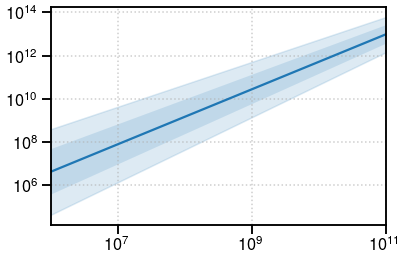

In [271]:
draw = np.random.multivariate_normal(fiducial[:2],cov_params_Y10[:2,:2],size=1000)
LCO = np.logspace(6,11,2)
LIR = 10**(draw[None,:,0]*np.log10(LCO)[:,None]+draw[None,:,1])
pl.loglog(LCO,np.median(LIR,axis=1))
pl.fill_between(LCO,np.percentile(LIR,16,axis=1),np.percentile(LIR,84,axis=1),alpha=0.15)
pl.fill_between(LCO,np.percentile(LIR,2.5,axis=1),np.percentile(LIR,97.5,axis=1),color='C0',alpha=0.15)
pl.grid(True,alpha=0.63,ls=':')
pl.autoscale(tight=True,axis='x')

[[<matplotlib.lines.Line2D at 0x2cf15a410>],

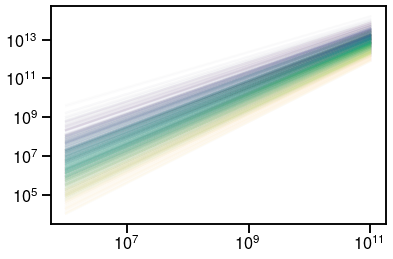

In [386]:
[pl.loglog(LCO,LIR_,c=pl.cm.viridis(betaIRCO*2-2),alpha=0.01) for LIR_,alphaIRCO in zip(LIR.T,draw[:,0])]

[[<matplotlib.lines.Line2D at 0x2c84bd6f0>],

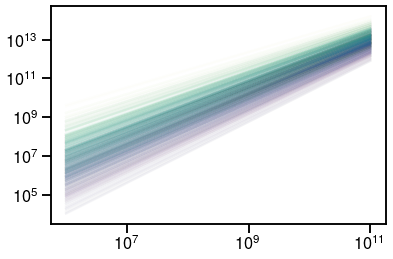

In [387]:
[pl.loglog(LCO,LIR_,c=pl.cm.viridis(alphaIRCO*0.1+0.5),alpha=0.01) for LIR_,alphaIRCO in zip(LIR.T,draw[:,1])]

Actually, while we have this draw, we can use it to get $\rho_\text{H2}$ intervals!

In [238]:
alpha_CO_H2 = 3.6 # Msol per observer integrated luminosity

One last grid of stuff:

In [239]:
dndlog10m = []
for z in zbins:
    h_for_Dz.update(z=z)
    dndlog10m.append(h_for_Dz.dndlog10m)

In [242]:
rhoH2_fid = [alpha_CO_H2*np.trapz(dndlog10m_*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,z_)*1.5)\
                                          +9.76-fiducial[1])/fiducial[0]),np.log10(h.m))*littleh**3 for z_,dndlog10m_ in zip(zbins,dndlog10m)]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/1046382591.py:1: RuntimeWarning: divide by zero encountered in log10
  rhoH2_fid = [alpha_CO_H2*np.trapz(dndlog10m_*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,z_)*1.5)\


In [243]:
rhoH2_draws = [alpha_CO_H2*np.trapz(dndlog10m_*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,z_)*1.5)[None,:]\
                                          +9.76-draw[:,1][:,None])/draw[:,0][:,None]),np.log10(h.m))*littleh**3 for z_,dndlog10m_ in zip(zbins,dndlog10m)]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/3609361144.py:1: RuntimeWarning: divide by zero encountered in log10
  rhoH2_draws = [alpha_CO_H2*np.trapz(dndlog10m_*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,z_)*1.5)[None,:]\


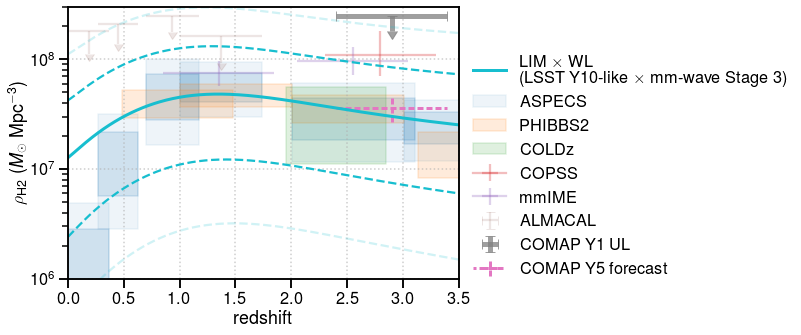

In [380]:
BASE_ALPHA = 0.15
pl.figure(figsize=(7,5))#.set_tight_layout(True)
pl.semilogy(zbins,rhoH2_fid,'C9',lw=3,label='LIM $\\times$ WL\n(LSST Y10-like $\\times$ mm-wave Stage 3)')
[pl.semilogy(zbins,np.percentile(np.array(rhoH2_draws),pct,axis=1),'C9',ls='--') for pct in (16,84)]
[pl.semilogy(zbins,np.percentile(np.array(rhoH2_draws),pct,axis=1),'C9',ls='--',alpha=0.2) for pct in (2.5,97.5)]
pl.fill_between((2.008,3.107),(1.164e7,)*2,(6.007e7,)*2,label='ASPECS',alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((2.008,3.107),(1.844e7,)*2,(4.438e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((1.006,1.738),(2.953e7,)*2,(9.462e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((1.006,1.738),(4.053e7,)*2,(7.489e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.003,0.369),(0.002e7,)*2,(0.485e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((0.003,0.369),(0.015e7,)*2,(0.281e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((3.011,4.475),(1.193e7,)*2,(4.220e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((3.011,4.475),(1.686e7,)*2,(3.289e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.271,0.631),(0.286e7,)*2,(3.181e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((0.271,0.631),(0.572e7,)*2,(2.148e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.695,1.174),(1.652e7,)*2,(10.02e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((0.695,1.174),(2.772e7,)*2,(7.371e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.4799,1.4799),(29.31e6,)*2,(52.38e6,)*2,label='PHIBBS2',alpha=BASE_ALPHA,color='C1')
pl.fill_between((1.0056,2.0056),(36.55e6,)*2,(59.98e6,)*2,alpha=BASE_ALPHA,color='C1')
pl.fill_between((2.0084,3.0084),(26.27e6,)*2,(46.95e6,)*2,alpha=BASE_ALPHA,color='C1')
pl.fill_between((3.1404,4.1404),( 8.22e6,)*2,(21.76e6,)*2,alpha=BASE_ALPHA,color='C1')
pl.fill_between((4.2451,5.2451),( 3.83e6,)*2,(16.58e6,)*2,alpha=BASE_ALPHA,color='C1')
pl.fill_between((1.95,2.85),(1.1e7,1.1e7),(5.6e7,5.6e7),label='COLDz',alpha=BASE_ALPHA,color='C2')
#pl.errorbar(3,2e7,1,label=' ',alpha=0)
pl.errorbar(2.8,1.1e8,yerr=np.array(((0.4,0.7),)).T*1e8,xerr=0.5,label='COPSS',color='C3',alpha=2*BASE_ALPHA)
pl.errorbar(2.55,9.7e7,yerr=np.array(((2.5,3.2),)).T*1e7,xerr=0.5,label='mmIME',color='C4',alpha=2*BASE_ALPHA)
pl.errorbar(1.35,7.5e7,yerr=np.array(((1.8,2.2),)).T*1e7,xerr=0.5,color='C4',alpha=2*BASE_ALPHA)
_,c,_ = pl.errorbar(0.186,10**8.26,yerr=0.7e8,xerr=0.183,uplims=True,label='ALMACAL',color='C5',linestyle='',alpha=BASE_ALPHA)
#c[0].set_alpha(0)
pl.errorbar(0.45095,10**8.32,yerr=0.7e8,xerr=0.17965,uplims=True,color='C5',alpha=BASE_ALPHA)
pl.errorbar(0.9347,10**8.39,yerr=0.7e8,xerr=0.2397,uplims=True,color='C5',alpha=BASE_ALPHA)
pl.errorbar(1.372,10**8.21,yerr=0.7e8,xerr=0.366,uplims=True,color='C5',alpha=BASE_ALPHA)
_,c,_ = pl.errorbar(2.9,2.5e8,yerr=0.7e8,xerr=0.5,uplims=True,label='COMAP Y1 UL',color='C7',lw=5,capsize=5,linestyle='',alpha=5*BASE_ALPHA)
_,c,cc = pl.errorbar(2.9,3.6e7,yerr=0.9e7,xerr=0.5,label='COMAP Y5 forecast',color='C6',lw=3,ls=(1,(2,1)))
cc[0].set_linestyle((0, (2,1)))
cc[1].set_linestyle((0, (2,1)))
'''
_,c,cc = pl.errorbar(2.9,9.0e7,yerr=2.7e7,xerr=0.5,label='Li+2016--Keating+2020',color='C8',lw=2,ls=(1,(2,1)))
pl.errorbar(2.9,9.0e7,yerr=0.47e7,xerr=0.5,label='\\emph{---stronger model assumptions}',color='C9',lw=1,ls=(1,(2,1)),capsize=5)
cc[0].set_linestyle((0, (2,1)))
cc[1].set_linestyle((0, (2,1)))
'''
pl.gca().set_yscale('log')
pl.ylabel('$\\rho_\\text{H2}$ ($M_\\odot$ Mpc$^{-3}$)')
pl.xlabel('redshift')
pl.grid(True,ls=':',alpha=0.63)
pl.xlim(0,3.5)
pl.ylim(1e6,3e8)
pl.legend(loc='lower left',frameon=False,bbox_to_anchor=(1,-0.05))
pl.savefig('rhoH2_illust.pdf',bbox_inches='tight')
pl.savefig('rhoH2_illust.png',bbox_inches='tight',dpi=288)

Interesting results all around really---this is not a very good constraint on the CO luminosity density at all, but on the other hand we did see some constraining power on $A_\text{IA}$ by Y10 x C+S3 ...

## An appendix of sorts
Here we're just showing the difference between the linear and nonlinear power spectra, the kmin and kmax corresponding to lmin=200 and lmax=2000 as a function of redshift, and the fact that incorporating the NFW profile makes essentially zero difference to the 2-halo term.

(100.0, 100000.0)

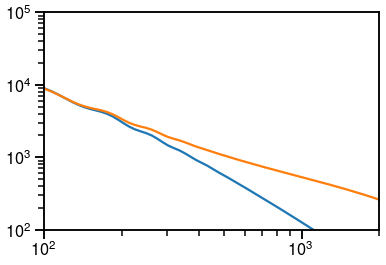

In [406]:
pl.loglog(h.k*littleh*cosmo.comoving_distance(0.5),h.power)
pl.loglog(h.k*littleh*cosmo.comoving_distance(0.5),h.nonlinear_power)
pl.xlim(1e2,2e3)
pl.ylim(1e2,1e5)

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_29538/704597843.py:1: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogy(zbins,2000/cosmo.comoving_distance(zbins).value)


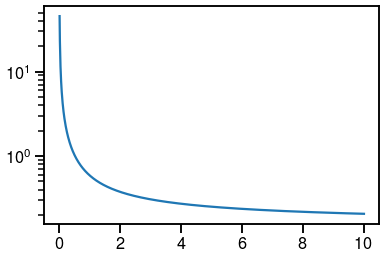

In [179]:
pl.semilogy(zbins,2000/cosmo.comoving_distance(zbins).value)

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_29538/2876375811.py:1: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogy(zbins,200/cosmo.comoving_distance(zbins).value)


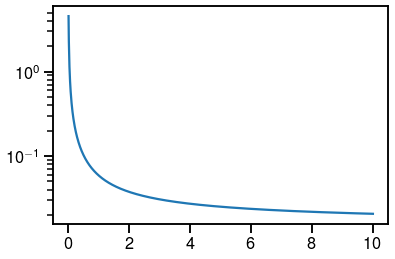

In [184]:
pl.semilogy(zbins,200/cosmo.comoving_distance(zbins).value)

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_29538/3719914040.py:1: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogy(zbins,2000/cosmo.comoving_distance(zbins).value)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_29538/3719914040.py:2: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogy(zbins,200/cosmo.comoving_distance(zbins).value)


(0.0, 1.0)

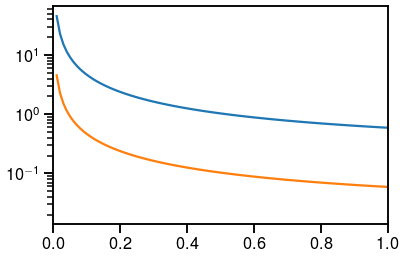

In [404]:
pl.semilogy(zbins,2000/cosmo.comoving_distance(zbins).value)
pl.semilogy(zbins,200/cosmo.comoving_distance(zbins).value)
pl.xlim(0,1)

In [426]:
200/cosmo.comoving_distance(0.15).value

0.31240395097453444

In [427]:
200/cosmo.comoving_distance(8.51).value

0.02153432964014203

In [390]:
import halomod

/Users/thete/Library/Python/3.10/lib/python/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


In [389]:
kbins = np.logspace(-2,2,401)

Text(0, 0.5, 'u(k,M)')

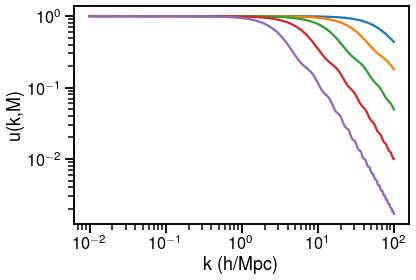

In [442]:
[pl.loglog(kbins,halomod.profiles.NFW(halomod.concentration.Duffy08(),z=0.2).u(kbins,1e10*10**i)) for i in range(5)]
pl.xlabel('k (h/Mpc)')
pl.ylabel('u(k,M)')

Text(0, 0.5, 'u(k,M)')

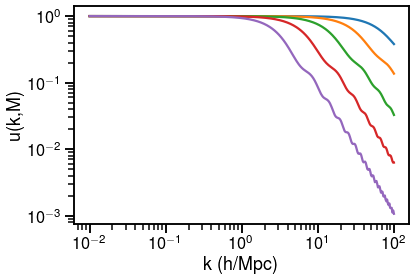

In [443]:
[pl.loglog(kbins,halomod.profiles.NFW(halomod.concentration.Duffy08(),z=2).u(kbins,1e10*10**i)) for i in range(5)]
pl.xlabel('k (h/Mpc)')
pl.ylabel('u(k,M)')

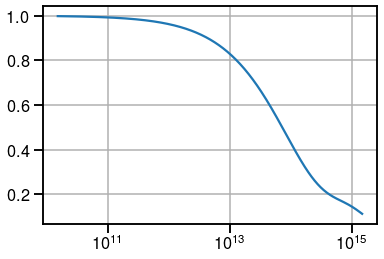

In [438]:
pl.semilogx(h.m/littleh,halomod.profiles.NFW(halomod.concentration.Duffy08(),z=0.2).u(3/littleh,h.m))
pl.grid(True)

In [439]:
halomod.profiles.NFW(halomod.concentration.Duffy08(),z=0.2).u(3/littleh,1e12)

0.9497635207342418

In [440]:
halomod.profiles.NFW(halomod.concentration.Duffy08(),z=0.2).u(3/littleh,1e13)

0.7800406573259412

In [400]:
Ib_CO_CI_scaledep = {J:[\
                        (CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                         np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*\
                                  halomod.profiles.NFW(halomod.concentration.Duffy08(),z=115.27*J/nuobs-1).u(kbins,h.m)*\
                                  10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3,np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3\
                        ).to(au.Jy/au.sr).value if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

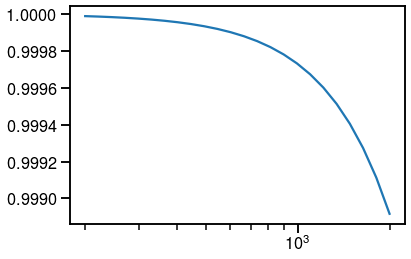

In [425]:
pl.semilogx(ellbins,spint.interp1d(kbins,Ib_CO_CI_scaledep[3][-1])(ellbins/cosmo.comoving_distance((115.27*3*au.GHz/nus-1)[i]).value)/Ib_CO_CI[3][-1])

In [223]:
for ii,J in enumerate(Js):
    Cl_scaledep = [1/deltachi_CO_CI[J][i]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i])**2*(Pshot_CO_CI[J][i]+spint.interp1d(kbins,Ib_CO_CI_scaledep[J][i])(ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value)**2*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value))*au.Mpc**3 for i in range(len(nus.value))]
    Cl_noscaled = [1/deltachi_CO_CI[J][i]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i])**2*(Pshot_CO_CI[J][i]+Ib_CO_CI[J][i]**2*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value))*au.Mpc**3 for i in range(len(nus.value))]
    print(np.any((np.array(Cl_scaledep)-np.array(Cl_noscaled))/np.array(Cl_scaledep)>0.001))

False
False
False
False
False
False


In [203]:
P1h_CO_CI = {J:[\
                (CLI(115.27*J/nuobs-1,115.27*J*au.GHz)**2*\
                 np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*\
                          halomod.profiles.NFW(halomod.concentration.Duffy08(),z=115.27*J/nuobs-1).u(ellbins/cosmo.comoving_distance(115.27*J/nuobs-1).value,h.m)**2*\
                          (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3)**2,np.log10(h.m))*au.Lsun**2/au.Mpc**3*littleh**3\
                ).to((au.Jy/au.sr)**2*au.Mpc**3).value if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

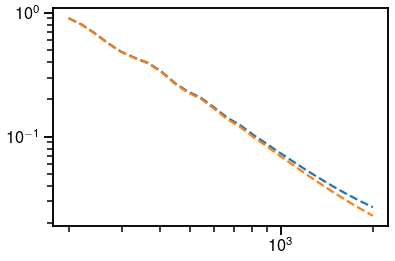

In [204]:
pl.loglog(ellbins,1/deltachi_CO_CI[3][21]/cosmo.comoving_distance((115.27*Js[3]*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[3][21]+P1h_CO_CI[3][21]+Ib_CO_CI[3][21]**2*Pm_for_CO_CI[3][21](ellbins/cosmo.comoving_distance((115.27*Js[3]*au.GHz/nus-1)[21]).value))*au.Mpc**3,ls='--')
pl.loglog(ellbins,1/deltachi_CO_CI[3][21]/cosmo.comoving_distance((115.27*Js[3]*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[3][21]+Ib_CO_CI[3][21]**2*Pm_for_CO_CI[3][21](ellbins/cosmo.comoving_distance((115.27*Js[3]*au.GHz/nus-1)[21]).value))*au.Mpc**3,ls='--')

I mean, it makes a tiny bit of difference to the auto spectrum? But it's not massive and I suspect it will be damped by the fact that our signal is the cross spectrum and the uncertainty is already rising at high k due to shape noise.

In [206]:
h.mean_density0*littleh**2

39161183744.6803

In [209]:
(cosmo.Om0*cosmo.critical_density0).to(au.Msun/au.Mpc**3)

<Quantity 3.91611837e+10 solMass / Mpc3>

In [412]:
bm_for_2h_scaledep = []
for z in zbins:
    h_for_bm.update(z=z)
    bm_for_2h_scaledep.append(np.trapz(h_for_bm.dndlog10m*h_for_bm.m/h_for_bm.mean_density0*bofM(h_for_bm)*halomod.profiles.NFW(halomod.concentration.Duffy08(),z=z).u(kbins[None,:],h_for_bm.m),np.log10(h_for_bm.m)))

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/1115167297.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(kbins,zbins,np.array(bm_for_2h_scaledep)/np.array(bm_for_2h)[:,None])
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/1115167297.py:2: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogx(2000/cosmo.comoving_distance(zbins).value,zbins)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_32730/1115167297.py:3: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogx(200/cosmo.comoving_distance(zbins).value,zbins)


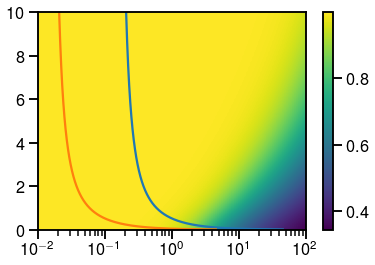

In [424]:
pl.pcolormesh(kbins,zbins,np.array(bm_for_2h_scaledep)/np.array(bm_for_2h)[:,None])
pl.semilogx(2000/cosmo.comoving_distance(zbins).value,zbins)
pl.semilogx(200/cosmo.comoving_distance(zbins).value,zbins)
pl.gca().set_xscale('log')
pl.colorbar()

In principle, given the relevant ranges of redshift and $k$, the NFW profile should not introduce significant scale-dependence in the matter bias in this context.

In [421]:
bm_normed_scaledep_interp = spint.RectBivariateSpline(zbins,kbins,np.array(bm_for_2h_scaledep)/np.array(bm_for_2h_norm)[:,None])

In [382]:
Cell_cross_Y10_1h = [sum(\
                         [(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                                   (Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                    WIA_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*\
                                   np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*h.m/h.mean_density0*\
                                            10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3*
                                   halomod.profiles.NFW(halomod.concentration.Duffy08(),z=115.27*J/nuobs-1).u((ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value),h.m)**2,\
                                            np.log10(h.m))*au.Lsun/\
                                   cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2).to(au.Jy/au.sr).value for J in Js])\
                     for i,nuobs in enumerate(nus.value)\
                    ]

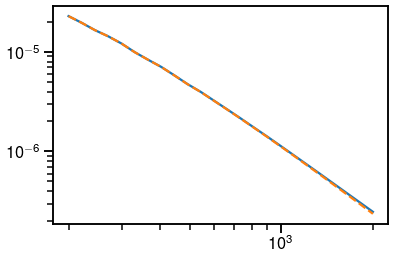

In [383]:
pl.loglog(ellbins,Cell_cross_Y10[EXAMPLE_CHANNEL]+Cell_cross_Y10_1h[EXAMPLE_CHANNEL])
pl.loglog(ellbins,Cell_cross_Y10[EXAMPLE_CHANNEL],'--')

In [291]:
J=3
i=EXAMPLE_CHANNEL
nuobs=nus.value[EXAMPLE_CHANNEL]

In [381]:
(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                                   (Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                    WIA_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*\
                                   np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*h.m/h.mean_density0*\
                                            10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3*
                                   halomod.profiles.NFW(halomod.concentration.Duffy08(),z=115.27*J/nuobs-1).u((ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value),h.m)**2,\
                                            np.log10(h.m))*au.Lsun/\
                                   cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2).to(au.Jy/au.sr)

<Quantity [2.11915528e-09, 2.11911800e-09, 2.11907245e-09, 2.11901682e-09,
           2.11894886e-09, 2.11886584e-09, 2.11876443e-09, 2.11864056e-09,
           2.11848927e-09, 2.11830448e-09, 2.11807879e-09, 2.11780317e-09,
           2.11746661e-09, 2.11705566e-09, 2.11655395e-09, 2.11594152e-09,
           2.11519406e-09, 2.11428202e-09, 2.11316943e-09, 2.11181264e-09,
           2.11015871e-09, 2.10814352e-09, 2.10568958e-09, 2.10270346e-09] Jy / sr>

In [384]:
Ib_CO_CI[J][i]*bm_for_2h_CO_CI[J][i]/bm_for_2h_CO_CI_norm[J][i]*(Wkappa_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+WIA_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2

<Quantity [4.50620478e-06, 4.09968782e-06, 3.52889529e-06, 2.83267456e-06,
           2.35347047e-06, 2.08370362e-06, 1.73518627e-06, 1.39713224e-06,
           1.19370204e-06, 9.74757135e-07, 8.02927544e-07, 6.58463674e-07,
           5.37984441e-07, 4.37467573e-07, 3.55478347e-07, 2.87259883e-07,
           2.31626965e-07, 1.86273679e-07, 1.49221009e-07, 1.19310129e-07,
           9.53438450e-08, 7.58076020e-08, 6.02620009e-08, 4.79042779e-08]>

In [387]:
np.max(np.array(Cell_cross_Y10_1h)/np.array(Cell_cross_Y10))

0.11011996987259086

In [389]:
for ii,J in enumerate(Js):
    print(np.max(np.array(P1h_CO_CI[J])/np.array([(Pshot_CO_CI[J][i]+Ib_CO_CI[J][i]**2*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value)) for i in range(len(nus.value))])))

0.4002232921889598
0.3385664204626091
0.3211324069884167
0.2869368844769016
0.26044100858876423
0.243559550750164


So the 1-halo term has at most an order-of-unity effect on both the auto LIM and cross LIM-shear power spectrum.

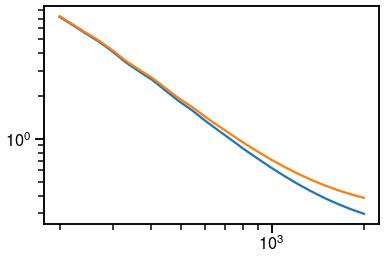

In [393]:
pl.loglog(ellbins,sum([(Pshot_CO_CI[J][EXAMPLE_CHANNEL]+Ib_CO_CI[J][EXAMPLE_CHANNEL]**2*Pm_for_CO_CI[J][EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))/deltachi_CO_CI[J][EXAMPLE_CHANNEL]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2 for J in Js]))
pl.loglog(ellbins,sum([(Pshot_CO_CI[J][EXAMPLE_CHANNEL]+P1h_CO_CI[J][EXAMPLE_CHANNEL]+Ib_CO_CI[J][EXAMPLE_CHANNEL]**2*Pm_for_CO_CI[J][EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))/deltachi_CO_CI[J][EXAMPLE_CHANNEL]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2 for J in Js]))

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_29538/883572536.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(ellbins,nus.value,[sum([(Pshot_CO_CI[J][i]+Ib_CO_CI[J][i]**2*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value))/deltachi_CO_CI[J][i]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i])**2 for J in Js])/sum([(Pshot_CO_CI[J][i]+P1h_CO_CI[J][i]+Ib_CO_CI[J][i]**2*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value))/deltachi_CO_CI[J][i]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i])**2 for J in Js]) for i in range(len(nus.value))])


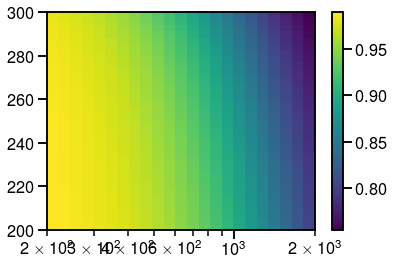

In [397]:
pl.pcolormesh(ellbins,nus.value,[sum([(Pshot_CO_CI[J][i]+Ib_CO_CI[J][i]**2*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value))/deltachi_CO_CI[J][i]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i])**2 for J in Js])/sum([(Pshot_CO_CI[J][i]+P1h_CO_CI[J][i]+Ib_CO_CI[J][i]**2*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value))/deltachi_CO_CI[J][i]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i])**2 for J in Js]) for i in range(len(nus.value))])
pl.gca().set_xscale('log')
pl.colorbar()

In [403]:
deltachi_CO_CI[3]

<Quantity [50.02326371, 50.04430447, 50.06065418, 50.07225539, 50.07905314,
           50.08099515, 50.07803189, 50.07011672, 50.05720601, 50.03925924,
           50.01623913, 49.98811173, 49.95484648, 49.9164164 , 49.87279806,
           49.82397176, 49.76992154, 49.71063527, 49.6461047 , 49.57632554,
           49.50129747, 49.42102418, 49.33551341, 49.24477697, 49.14883073,
           49.04769464, 48.94139271, 48.82995301, 48.7134076 , 48.59179257,
           48.46514792, 48.33351756, 48.19694921, 48.05549436, 47.90920819,
           47.75814947, 47.60238048, 47.44196689, 47.27697769, 47.10748505,
           46.9335642 , 46.7552933 ] Mpc>

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_29538/3246753822.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(ellbins,nus.value,np.array(Cell_cross_Y10_1h)/np.array(Cell_cross_Y10))


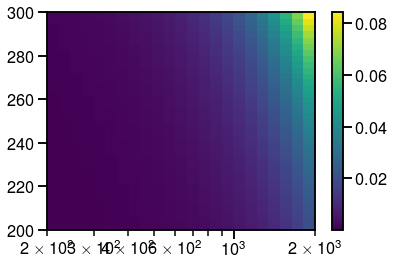

In [413]:
pl.pcolormesh(ellbins,nus.value,np.array(Cell_cross_Y10_1h)/np.array(Cell_cross_Y10))
pl.gca().set_xscale('log')
pl.colorbar()

In [ ]:
Cell_LIMLIM_with1h = np.zeros((len(nus.value),len(nus.value),len(ellbins)))
for i,nu in enumerate(nus.value):
    for ii,nu2 in enumerate(nus.value):
        # treating CII as its own special case
        if i==ii:
            Cell_LIMLIM_with1h[i,ii] += (1/deltachi_CII[i]*(Pshot_CII[i]+\
                                                            Ib_CII[i]**2*\
                        Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nu-1).value))*au.Mpc**3/\
                                    cosmo.comoving_distance(1901.0302/nu-1)**2).to(1).value
        # now iterate through CO and CI using our table for Theta
        for J,rJ in zip(Js,rJs):
            for J2,rJ2 in zip(Js,rJs):
                if Theta_switchertable[(nu,nu2,J,J2)]:
                    deltachi_avg = np.sqrt(deltachi_CO_CI[J][i]*deltachi_CO_CI[J2][ii])
                    chi_avg = np.sqrt(cosmo.comoving_distance(115.27*J/nu-1)*\
                                       cosmo.comoving_distance(115.27*J2/nu2-1))
                    dndlog10m_avg = (hmfs_for_CO_CI[J][nu].dndlog10m+hmfs_for_CO_CI[J2][nu2].dndlog10m)/2
                    LofM_J = (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nu-1)*1.5)+\
                                                10.76)/1.27-4.31)*rJ*J**3)
                    LofM_J2 = (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J2/nu2-1)*1.5)+\
                                                10.76)/1.27-4.31)*rJ2*J2**3)
                    Pshot_cross = Pshot_scatter_factor*(CLI(115.27*J/nu-1,115.27*J*au.GHz)*\
                                                        CLI(115.27*J2/nu2-1,115.27*J2*au.GHz)*\
                                        np.trapz(dndlog10m_avg*LofM_J*LofM_J2,np.log10(h.m))*au.Lsun**2/au.Mpc**3*\
                                                        littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value
                    P1h_cross = (CLI(115.27*J/nu-1,115.27*J*au.GHz)*CLI(115.27*J2/nu2-1,115.27*J2*au.GHz)*\
                                        np.trapz(dndlog10m_avg*LofM_J*LofM_J2,np.log10(h.m))*au.Lsun**2/au.Mpc**3*\
                                                        littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value
                    Cell_LIMLIM_with1h[i,ii] += (1/deltachi_avg/chi_avg**2*\
                        (Pshot_cross+Ib_CO_CI[J][i]*Ib_CO_CI[J2][ii]*\
                         10**Plininterp(np.ones_like(ellbins)*chi_avg.value,np.log10(ellbins/chi_avg.value),\
                                  grid=False))*au.Mpc**3).to(1).value